# Example: Ornstein-Uhlenbeck process

For more information of the OU process please visit: https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process

In [1]:
# General imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splev, splrep

# Import local HMC implementation.
from src.hmc_sampler import HMC

In [2]:
# Potential energy function.
def Epot_OU(x, func, n_dim, p_obs, p_theta, p_sigma, n_obs, idx, y, dt):
    
    # Make sure the input x is an array.
    x = np.asarray(x, dtype=float).flatten()
    
    # Logarithm of 2 x pi.
    log2pi = 1.83787706640935

    # Precompute the n-th difference.
    diff_x = np.diff(x, n=1)/dt

    # Precompute F(x).
    Fx = func(x, p_theta)

    # Initialize energy values.
    Esde = np.zeros(n_dim-1)

    # Energy from the sDyn (dynamics of the system).
    for k in range(n_dim-1):
        Esde[k] = ((diff_x[k] - Fx[k])**2)/p_sigma
    # _end_for_

    # Scale the result correctly and add the normalization constant.
    Esde = np.sum(Esde)*dt + (n_dim-1)*(log2pi + np.log(p_sigma*dt))

    # Energy from the Obs. (measurements).
    Eobs = ((x[idx]-y)**2)/p_obs

    # Add the normalization constant.
    Eobs = np.sum(Eobs) + n_obs*(log2pi + np.log(p_obs))

    # Now compute the contribution of the initial state
    # with prior mean 'mu' and prior covariance 'tau' ,
    # or p(x0) = N(x0|mu0,tau0).
    mu0, tau0 = 0.0, 1.0

    # Evaluate the log-Gaussian at x(t=0), i.e. log(p(x0)).
    E0 = log2pi + np.log(tau0) + ((x[0] - mu0)**2)/tau0
    
    # Return the total potential energy of the system.
    return 0.5*(E0 + Esde + Eobs)
# _end_def_
                                  
# Drift function.
def func_OU(x, theta):
    return -theta*x
# _end_def_

# Gradient function.
def grad_OU(x, n_dim, p_obs, p_theta, p_sigma, dt, idx, y):
    # Preallocate return vector.
    grad_x = np.zeros(n_dim)

    # Prior mean and variance (for p(X0)).
    mu0, tau0 = 0.0, 1.0

    # Reshape the X vector correctly.
    x = np.asarray(x, dtype=float).flatten()
    
    # Precompute the differences.
    diff_x = np.diff(x, n=1)/dt
    
    # Gradient at initial time, X(t=0).
    grad_x[0] = (diff_x[0] + p_theta*x[0])*(dt*p_theta - 1.0)/p_sigma + (x[0]-mu0)/tau0

    # Gradients at X_{1:N-1}
    for k in range(1, n_dim-1):
        grad_x[k] = (diff_x[k-1] + p_theta*x[k-1])/p_sigma - (diff_x[k] + p_theta*x[k])*(1.0 - p_theta*dt)/p_sigma
    # _end_for_

    # Gradient at final time, X(t=N).
    grad_x[-1] = (diff_x[-1] + p_theta*x[-2])/p_sigma

    # Add the contribution from the observations.
    grad_x[idx] = grad_x[idx] + (x[idx] - y)/p_obs
    
    # dF/dx.
    return grad_x
# _end_def_

In [3]:
# Create a stochastic sample path.
def path_OU(t0, tf, dt, K, theta, mu = 0.0):
    
    # Number of actual trajectory samples.
    n_dim = np.arange(t0, tf, dt).size

    # Initialize array.
    X = np.zeros(n_dim)
    
    # Noise variance coefficient.
    scale = np.sqrt(K*dt)
    
    # Localize the N(0,1).
    en = np.random.randn

    # Create the Sample path.
    for t in range(1, n_dim):
        X[t] = X[t-1] + theta*(mu - X[t-1])*dt + scale*en()
    # _end_for_
    
    # Discrete sample path.
    return X
# _end_def_

In [7]:
# Stochastic noise (variance).
p_sigma = 1.0

# Drift parameter.
p_theta = 2.0

# Time-discretisations.
t0, tf, dt = 0, 10, 0.01

# Number of discrete time-points.
n_dim = np.arange(t0, tf, dt).size

# Create the (artificial) true trajectory.
Xt = path_OU(t0, tf, dt, p_sigma, p_theta)

In [8]:
# Define the number of observations per time unit.
n_obs = 2

# Observation noise (variance).
p_obs = 0.04

# Total number of observations.
total_obs = np.abs(tf-t0)*n_obs

# Find the indexes. Assume the observations are equally spaced.
indices = np.linspace(1, Xt.size-1, num=total_obs, dtype=int)

# Collect the observations from the current path (trajectory).
obs = np.take(Xt, indices)

# Add Gaussian i.i.d. noise.
obs += np.sqrt(p_obs)*np.random.randn(obs.size)

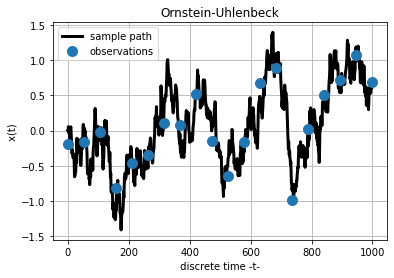

In [9]:
# Plot the path and the noisy observations.
plt.plot(Xt, 'k', label="sample path", linewidth=3)
plt.plot(indices, obs, 'o', markersize=10, label="observations")
plt.grid(True)
plt.xlabel(" discrete time -t- ")
plt.ylabel(" x(t) ")
plt.title("Ornstein-Uhlenbeck")
plt.legend();

In [10]:
# Create the initial sample path (t=0) using b-splines.
B_spl = splrep(indices*dt, obs, k=3)

# Evaluate the spline at the required time points.
x0 = splev(np.arange(t0, tf, dt), B_spl)

Text(0.5, 1.0, 'Initial path')

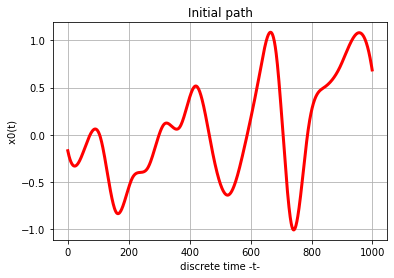

In [12]:
# Plot the initial sample path.
plt.plot(x0, 'r', linewidth=3)

plt.grid(True)

plt.xlabel(" discrete time -t- ")

plt.ylabel(" x0(t) ")

plt.title("Initial path");

In [14]:
# Function handles.
_func = lambda x: Epot_OU(x, func_OU, n_dim, p_obs, p_theta, p_sigma, n_obs, indices, obs, dt)
_grad = lambda x: grad_OU(x, n_dim, p_obs, p_theta, p_sigma, dt, indices, obs)

# Create an HMC object.
oup_hmc = HMC(_func, _grad, n_omitted=1000, n_samples=5000,
              verbose=True, grad_check=True, rng_seed=911,
              kappa=100, d_tau=0.01)

# Print out the settings.
print(oup_hmc)

 HMC Id(4825389440): 
 Func(x)=<function <lambda> at 0x11f9e2040> 
 Grad(x)=<function <lambda> at 0x11f9e2160> 
 Options:
 	n_samples: 5000
	n_omitted: 1000
	kappa: 100
	d_tau: 0.01
	grad_check: True
	generalized: False
	verbose: True
	rng_seed: RandomState(MT19937)



In [15]:
# Run the sampling from x0 starting point.
results = oup_hmc(x0=x0)

Checking gradients <BEFORE> sampling ... 
Error <BEFORE> = 0.0002038739477630462
 >>> HMC started 


 Iter=4500 - E=-889.591 - Acceptance=0.945: 100%|██████████| 6000/6000 [20:42<00:00,  4.83it/s]


 >>> HMC finished in 1242.396 seconds.
Checking gradients <AFTER> sampling ... 
Error <AFTER> = 0.00011887672691886589


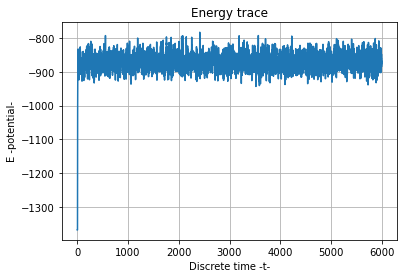

In [16]:
# Energy trace plot.
plt.plot(results["Energies"])

plt.title("Energy trace")

plt.xlabel("Discrete time -t-")

plt.ylabel("E -potential-")

plt.grid(True)

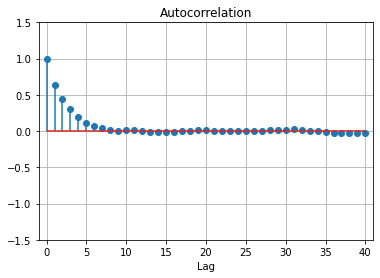

In [17]:
# ACF lag value.
lag_n = 40

# Plot the ACF.
plt.stem(oup_hmc.acf(lag_n=lag_n));

plt.grid(True);

plt.title("Autocorrelation");

plt.xlim([-1, lag_n+1])

plt.ylim([-1.5, 1.5])

plt.xticks(range(0, lag_n+1, 5))

plt.xlabel("Lag");

In [18]:
# Convert to pandas.
df = pd.DataFrame(results["Samples"])

# Estimate the mean/std of the samples.
mean_x, std_x = df.mean(), df.std()

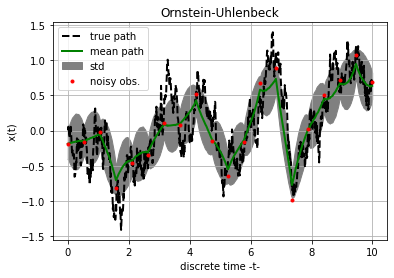

In [19]:
# Time window.
Tk = np.arange(t0, tf, dt)

# True OU path.
plt.plot(Tk, Xt, 'k--', label="true path", linewidth=2)

# Sample mean.
plt.plot(Tk, mean_x, 'g-', label="mean path", linewidth=2)

# Sample std (filled envelope).
plt.fill_between(Tk, mean_x-std_x, mean_x+std_x, label="std", color="gray")

# Noisy observations.
plt.plot(indices*dt, obs, 'ro', markersize=3, label="noisy obs.")

plt.title("Ornstein-Uhlenbeck")
plt.xlabel(" discrete time -t- ")
plt.ylabel(" x(t) ")

plt.grid(True)

plt.legend();